### Installs & Imports

In [18]:
!pip install --upgrade pip

!pip install numpy pandas seaborn matplotlib scikit-learn nltk spacy langdetect emoji simpletransformers optuna statsmodels

In [1]:
# System & Utility Libraries
import optuna
import os
import json
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from io import StringIO
import joblib

# NLTK NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Spacy NLP
import spacy
from spacy.tokens import Doc

# Scikit-learn & ML Libraries
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold


# Language Detection
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Emoji Handling
import emoji

# SimpleTransformers for Deep Learning Models
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# Z-test for statistical analysis
from statsmodels.stats.proportion import proportions_ztest

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lazargyoshev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lazargyoshev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lazargyoshev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lazargyoshev/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lazargyoshev/nltk_data...
[nltk_data]   P

# 1. Named Entity Recognition & Classification

### Training & Validation Sets

#### Distribution Analysis

In [3]:
label_mapping = {
    0: 'O', 1: 'B-CARDINAL', 2: 'B-DATE', 3: 'I-DATE', 4: 'B-PERSON', 5: 'I-PERSON',
    6: 'B-NORP', 7: 'B-GPE', 8: 'I-GPE', 9: 'B-LAW', 10: 'I-LAW', 11: 'B-ORG',
    12: 'I-ORG', 13: 'B-PERCENT', 14: 'I-PERCENT', 15: 'B-ORDINAL', 16: 'B-MONEY',
    17: 'I-MONEY', 18: 'B-WORK_OF_ART', 19: 'I-WORK_OF_ART', 20: 'B-FAC',
    21: 'B-TIME', 22: 'I-CARDINAL', 23: 'B-LOC', 24: 'B-QUANTITY', 25: 'I-QUANTITY',
    26: 'I-NORP', 27: 'I-LOC', 28: 'B-PRODUCT', 29: 'I-TIME', 30: 'B-EVENT',
    31: 'I-EVENT', 32: 'I-FAC', 33: 'B-LANGUAGE', 34: 'I-PRODUCT', 35: 'I-ORDINAL',
    36: 'I-LANGUAGE'
}

In [4]:
# Training data (merge 5 files together - we use the original four training files and valiadation as training data)
# a new file called 'merged_word_train_val' is created as a result of the merging and conversion of
# sentence instances to word instances and is saved in the folder
train_val_files = ["Training Data/NERC Data/Original/train00.json", "Training Data/NERC Data/Original/train01.json", "Training Data/NERC Data/Original/train02.json",
                    "Training Data/NERC Data/Original/train03.json", "Training Data/NERC Data/Original/valid.json"]

output_file = "Training Data/NERC Data/merged_word_train_val.json"

word_instances = []
sentence_id = 0

for file in train_val_files:
    with open(file, "r", encoding="utf-8") as in_file:
        for line in in_file:
            sentence = json.loads(line)
            tokens = sentence["tokens"]
            ner_tags = sentence["tags"]

            for token_id, (token, ner_tag) in enumerate(zip(tokens, ner_tags)):
                word_instance = {
                    "sentence_id": sentence_id,
                    "token_id": token_id,
                    "token": token,
                    "BIO_NER_tag": label_mapping.get(ner_tag, "O")  # Map numeric tag to IOB format
                }
                word_instances.append(word_instance)

            # Increment the sentence ID
            sentence_id += 1

# Save the transformed data to a new JSON file
with open(output_file, "w", encoding="utf-8") as out_file:
    for instance in word_instances:
        out_file.write(json.dumps(instance) + "\n")

In [5]:
# Validation data (we use the original test data as validation data)
# a new file called 'merged_word_test' is created as a result of the merging and conversion of
# sentence instances to word instances and is saved in the folder
test_file = "Training Data/NERC Data/Original/test.json"
output_file = "Training Data/NERC Data/word_test.json"

word_instances = []
sentence_id = 0

with open(test_file, "r", encoding="utf-8") as in_file:
    for line in in_file:
            sentence = json.loads(line)
            tokens = sentence["tokens"]
            ner_tags = sentence["tags"]

            # Convert sentence instances to word instances
            for token_id, (token, ner_tag) in enumerate(zip(tokens, ner_tags)):
                word_instance = {
                    "sentence_id": sentence_id,
                    "token_id": token_id,
                    "token": token,
                    "BIO_NER_tag": label_mapping.get(ner_tag, "O")  # Map numeric tag to IOB format
                }
                word_instances.append(word_instance)

            # Increment the sentence ID
            sentence_id += 1

# Save the transformed data to a new JSON file
with open(output_file, "w", encoding="utf-8") as out_file:
    for instance in word_instances:
        out_file.write(json.dumps(instance) + "\n")


In [6]:
def ner_distribution_table(file_path):
    """
    Creates a dataframe showing the count and percentage of each NER tag
    in the given dataset.
    """
    tags_list = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            tags_list.append(data['BIO_NER_tag'])

    # Count occurrences of each tag
    tag_counts = Counter(tags_list)

    # Convert counts to percentages
    total_tags = sum(tag_counts.values())
    tag_data = []
    for tag, count in tag_counts.items():
        tag_percentage = (count / total_tags) * 100
        tag_info = {"NER Label": tag, "Count": count, "Percentage": tag_percentage}
        tag_data.append(tag_info)

    # Create and return DataFrame
    df = pd.DataFrame(tag_data).sort_values(by="Percentage", ascending=False)
    df.reset_index(drop=True, inplace=True)
    df = df.set_index(keys="NER Label")

    return df

In [7]:
train_dtable = ner_distribution_table("Training Data/NERC Data/merged_word_train_val.json")
print(f"Number of instances in training data: {train_dtable["Count"].sum()}")
display(train_dtable)

Number of instances in training data: 1236160


,Count,Percentage
NER Label,,
O,1066810,86.300317
I-ORG,20582,1.664995
B-GPE,17673,1.429669
B-PERSON,17449,1.411549
I-DATE,15142,1.224922
B-ORG,14560,1.177841
I-PERSON,12542,1.014594
B-DATE,12429,1.005452
B-CARDINAL,8292,0.670787


In [8]:
val_dtable = ner_distribution_table("Training Data/NERC Data/word_test.json")
print(f"Number of instances in validation data: {val_dtable["Count"].sum()}")
display(val_dtable)

Number of instances in validation data: 152723


,Count,Percentage
NER Label,,
O,131814,86.309200
I-ORG,2406,1.575401
B-GPE,2240,1.466708
I-DATE,2011,1.316763
B-PERSON,1988,1.301703
B-ORG,1795,1.175331
B-DATE,1602,1.048958
I-PERSON,1412,0.924550
B-CARDINAL,935,0.612220


### Test Set

#### Distribution Analysis

In [9]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/NER-test.tsv'
test_data_df = pd.read_csv(file_path, delimiter='\t')

# Count occurrences of each tag
tag_counts = Counter(test_data_df['BIO_NER_tag'])

# Convert counts to percentages
total_tags = sum(tag_counts.values())
tag_data = []
for tag, count in tag_counts.items():
    tag_percentage = (count / total_tags) * 100
    tag_info = {"NER Label": tag, "Count": count, "Percentage": tag_percentage}
    tag_data.append(tag_info)

# Create and return DataFrame
distribution_df = pd.DataFrame(tag_data).sort_values(by="Percentage", ascending=False)
distribution_df.reset_index(drop=True, inplace=True)
distribution_df = distribution_df.set_index(keys="NER Label")

print(f"Number of instances in test data: {distribution_df["Count"].sum()}")
display(distribution_df)

Number of instances in test data: 237


,Count,Percentage
NER Label,,
O,186,78.481013
B-PERSON,11,4.641350
I-WORK_OF_ART,10,4.219409
B-WORK_OF_ART,9,3.797468
I-PERSON,8,3.375527
B-LOC,7,2.953586
B-ORG,3,1.265823
I-ORG,2,0.843882
I-LOC,1,0.421941


### Feature Engineering

In [ ]:
def get_shape(word):
    """
    Helper function that determines the shape of word.
    Inspired by the categories for shape in dataset ner_v2.csv used in Lab 4.
    """
    if word in ["__START1__", "__START2__", "__END1__", "__END2__"]:
        return "wildcard"
    elif word in string.punctuation:
        return "punctuation"
    elif "-" in word:
        return "contains-hyphen"
    elif "'" in word:
        return "other"
    elif "." in word and word.isupper():
            return "abbreviation"
    elif word.endswith(".") and word[:-1].isalpha():
        return "ending-dot"
    elif re.match(r'^[A-Z][a-z]+[A-Z][a-z]*$', word):
        return "camelcase"
    elif re.match(r'^(?=.*[a-z])(?=.*[A-Z])', word):
        return "mixedcase"
    elif word.isalpha():
        if word.istitle():
            return "capitalized"
        elif word.islower():
            return "lowercase"
        elif word.isupper():
            return "uppercase"
        else:
            return "other"
    elif word.isdigit():
        return "number"
    else:
        return "other"

In [ ]:
def data_to_features(df, nlp):
    """
    Process a dataframe by adding linguistic features using spaCy.
    - Adds POS tagging, lemmatization and shape features
    - Computes previous, before previous, next, and after next token and their lemma, POS tag and shape
    """
    # Add the POS tags and lemmas
    tokens = df["token"].to_list()
    document = Doc(nlp.vocab, words=tokens)

    # Manually run the tokens through the spaCy pipeline to avoid retokenization
    document = nlp.get_pipe("tok2vec")(document)
    document = nlp.get_pipe("tagger")(document)
    document = nlp.get_pipe("attribute_ruler")(document)
    document = nlp.get_pipe("lemmatizer")(document)

    pos_tags = []
    lemmas = []
    for token in document:
        pos_tags.append(token.tag_)
        lemmas.append(token.lemma_)

    df["POS_tag"] = pos_tags
    df["lemma"] = lemmas

    # Add the previous, before previous, next, and after next token and their lemmas and their POS tags
    df["prev_token"] = df["token"].shift(1).fillna("__START1__")
    df["prev_prev_token"] = df["token"].shift(2).fillna("__START2__")
    df["next_token"] = df["token"].shift(-1).fillna("__END1__")
    df["next_next_token"] = df["token"].shift(-2).fillna("__END2__")
    df["prev_lemma"] = df["lemma"].shift(1).fillna("__START1__")
    df["prev_prev_lemma"] = df["lemma"].shift(2).fillna("__START2__")
    df["next_lemma"] = df["lemma"].shift(-1).fillna("__END1__")
    df["next_next_lemma"] = df["lemma"].shift(-2).fillna("__END2__")
    df["prev_POS_tag"] = df["POS_tag"].shift(1).fillna("__START1__")
    df["prev_prev_POS_tag"] = df["POS_tag"].shift(2).fillna("__START2__")
    df["next_POS_tag"] = df["POS_tag"].shift(-1).fillna("__END1__")
    df["next_next_POS_tag"] = df["POS_tag"].shift(-2).fillna("__END2__")

    # Add the shape of each token
    df["shape"] = df["token"].apply(get_shape)
    df["prev_shape"] = df["prev_token"].apply(get_shape)
    df["next_shape"] = df["next_token"].apply(get_shape)
    df["prev_prev_shape"] = df["prev_prev_token"].apply(get_shape)
    df["next_next_shape"] = df["next_next_token"].apply(get_shape)

    # Reorder the columns
    df = df[["sentence_id", "token_id", "token", "shape",  "POS_tag", "lemma", "BIO_NER_tag",
        "prev_token", "prev_shape", "prev_POS_tag", "prev_lemma", "prev_prev_token", "prev_prev_shape",
        "prev_prev_POS_tag", "prev_prev_lemma", "next_token", "next_shape", "next_POS_tag", "next_lemma",
        "next_next_token", "next_next_shape", "next_next_POS_tag", "next_next_lemma"]]

    return df

In [ ]:
# Put the training and validation data into dataframes
train_data_file = "Training Data/NERC Data/merged_word_train_val.json"
val_data_file = "Training Data/NERC Data/word_test.json"
train_data = []
val_data = []

# Create a dataframe with the training data
with open(train_data_file, "r", encoding="utf-8") as file:
    for line in file:
        train_data.append(json.loads(line))
train_data_df = pd.read_json(StringIO(json.dumps(train_data)))

# Create a dataframe with the validation data
with open(val_data_file, "r", encoding="utf-8") as file:
    for line in file:
        val_data.append(json.loads(line))
val_data_df = pd.read_json(StringIO(json.dumps(val_data)))

In [ ]:
# Load English model for POS tagging
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
nlp.max_length = 7000000  # increase the max length to allow larger inputs

# Create more features from the data
train_data_df = data_to_features(train_data_df, nlp)
val_data_df = data_to_features(val_data_df, nlp)
test_data_df = data_to_features(test_data_df, nlp)

# Save the files with the features
train_data_df.to_csv("Training Data/NERC Data/train_features.csv", index=False, encoding="utf-8")
val_data_df.to_csv("Training Data/NERC Data/val_features.csv", index=False, encoding="utf-8")
test_data_df.to_csv("Test Data/NER_test_features.csv", index=False, encoding="utf-8")

In [2]:
# Loading from file, so previous cells do not have to be rerun every time
train_data_df = pd.read_csv("Training Data/NERC Data/train_features.csv", encoding = 'utf-8', keep_default_na=False)
val_data_df = pd.read_csv("Training Data/NERC Data/val_features.csv", encoding = 'utf-8', keep_default_na=False)
test_data_df = pd.read_csv("Test Data/NER_test_features.csv", encoding = 'utf-8', keep_default_na=False)

In [3]:
def prepare_data_for_vectorization(data, selected_features):
    """
    Prepares data for vectorization by extracting the selected features and the labels 
    of the instances from the dataframe and putting them into lists.
    For the features, a dictionary is used to represent each instance in the list.
    """
    features = []
    gold_labels = []

    # Iterate over each row of the dataframe
    for index, instance in data.iterrows():
        features_dict = {}      # Create a dictionary for the features of each instance
        for key, value in instance.items():
            if key in selected_features:
                features_dict[key] = value
            elif key == "BIO_NER_tag":
                ne_label = value

        # Append the features and NE label of the instance
        features.append(features_dict)
        gold_labels.append(ne_label)

    return features, gold_labels

In [4]:
# Subset of features used
selected_features_paper = ["token", "shape", "POS_tag", "prev_token", "next_token", "prev_POS_tag", "next_POS_tag", "sentence_id"] # features used in paper
selected_features_chosen = ["sentence_id", "token_id", "token", "shape",  "POS_tag", "lemma",
        "prev_token", "prev_shape", "prev_POS_tag", "prev_lemma", "prev_prev_token", "prev_prev_shape",
        "prev_prev_POS_tag", "prev_prev_lemma", "next_token", "next_shape", "next_POS_tag", "next_lemma",
        "next_next_token", "next_next_shape", "next_next_POS_tag", "next_next_lemma"]

# Prepare the data for vectorization
ner_train_features_paper, ner_train_gold_labels_paper = prepare_data_for_vectorization(train_data_df, selected_features_paper)
ner_val_features_paper, ner_val_gold_labels_paper = prepare_data_for_vectorization(val_data_df, selected_features_paper)
ner_test_features_paper, ner_test_gold_labels_paper = prepare_data_for_vectorization(test_data_df, selected_features_paper)

ner_train_features_chosen, ner_train_gold_labels_chosen = prepare_data_for_vectorization(train_data_df, selected_features_chosen)
ner_val_features_chosen, ner_val_gold_labels_chosen = prepare_data_for_vectorization(val_data_df, selected_features_chosen)
ner_test_features_chosen, ner_test_gold_labels_chosen = prepare_data_for_vectorization(test_data_df, selected_features_chosen)

In [5]:
# Check for selected_features_paper
print("Sample Training Feature:", ner_train_features_paper[21])
print("Sample Training Label:", ner_train_gold_labels_paper[21])
print("Sample Validation Feature:", ner_val_features_paper[11])
print("Sample Validation Label:", ner_val_gold_labels_paper[11])
print("Sample Test Feature:", ner_test_features_paper[19])
print("Sample Test Label:", ner_test_gold_labels_paper[19])

Sample Training Feature: {'sentence_id': 1, 'token': 'one', 'shape': 'lowercase', 'POS_tag': 'CD', 'prev_token': 'rarely', 'prev_POS_tag': 'RB', 'next_token': 'of', 'next_POS_tag': 'IN'}
Sample Training Label: B-CARDINAL
Sample Validation Feature: {'sentence_id': 0, 'token': 'U.S.', 'shape': 'abbreviation', 'POS_tag': 'NNP', 'prev_token': 'the', 'prev_POS_tag': 'DT', 'next_token': 'and', 'next_POS_tag': 'CC'}
Sample Validation Label: B-GPE
Sample Test Feature: {'sentence_id': 1, 'token': 'Elena', 'shape': 'mixedcase', 'POS_tag': 'NNP', 'prev_token': '.', 'prev_POS_tag': '.', 'next_token': 'and', 'next_POS_tag': 'CC'}
Sample Test Label: B-PERSON


In [6]:
# Check for selected_features_chosen
print("Sample Training Feature:", ner_train_features_chosen[21])
print("Sample Training Label:", ner_train_gold_labels_chosen[21])
print("Sample Validation Feature:", ner_val_features_chosen[11])
print("Sample Validation Label:", ner_val_gold_labels_chosen[11])
print("Sample Test Feature:", ner_test_features_chosen[19])
print("Sample Test Label:", ner_test_gold_labels_chosen[19])

Sample Training Feature: {'sentence_id': 1, 'token_id': 12, 'token': 'one', 'shape': 'lowercase', 'POS_tag': 'CD', 'lemma': 'one', 'prev_token': 'rarely', 'prev_shape': 'lowercase', 'prev_POS_tag': 'RB', 'prev_lemma': 'rarely', 'prev_prev_token': 'is', 'prev_prev_shape': 'lowercase', 'prev_prev_POS_tag': 'VBZ', 'prev_prev_lemma': 'be', 'next_token': 'of', 'next_shape': 'lowercase', 'next_POS_tag': 'IN', 'next_lemma': 'of', 'next_next_token': 'them', 'next_next_shape': 'lowercase', 'next_next_POS_tag': 'PRP', 'next_next_lemma': 'they'}
Sample Training Label: B-CARDINAL
Sample Validation Feature: {'sentence_id': 0, 'token_id': 11, 'token': 'U.S.', 'shape': 'abbreviation', 'POS_tag': 'NNP', 'lemma': 'U.S.', 'prev_token': 'the', 'prev_shape': 'lowercase', 'prev_POS_tag': 'DT', 'prev_lemma': 'the', 'prev_prev_token': 'in', 'prev_prev_shape': 'lowercase', 'prev_prev_POS_tag': 'IN', 'prev_prev_lemma': 'in', 'next_token': 'and', 'next_shape': 'lowercase', 'next_POS_tag': 'CC', 'next_lemma': 'a

In [7]:
# Check the number of instances in the training, validation, and test data for selected_features_paper
num_ner_train_instances_paper = len(ner_train_features_paper)
num_ner_val_instances_paper = len(ner_val_features_paper)
num_ner_test_instances_paper = len(ner_test_features_paper)

print(f"Number of instances in training data: {num_ner_train_instances_paper}")
print(f"Number of instances in validation data: {num_ner_val_instances_paper}")
print(f"Number of instances in test data: {num_ner_test_instances_paper}")

Number of instances in training data: 1236160
Number of instances in validation data: 152723
Number of instances in test data: 237


In [8]:
# Check the number of instances in the training, validation, and test data for selected_features_chosen
num_ner_train_instances_chosen = len(ner_train_features_chosen)
num_ner_val_instances_chosen = len(ner_val_features_chosen)
num_ner_test_instances_chosen = len(ner_test_features_chosen)

print(f"Number of instances in training data: {num_ner_train_instances_chosen}")
print(f"Number of instances in validation data: {num_ner_val_instances_chosen}")
print(f"Number of instances in test data: {num_ner_test_instances_chosen}")

Number of instances in training data: 1236160
Number of instances in validation data: 152723
Number of instances in test data: 237


In [9]:
# Concatenate the features lists of selected_features_paper and transform them to one hot encoding using DictVectorizer
vec1 = DictVectorizer()
ner_all_features_paper = ner_train_features_paper + ner_val_features_paper + ner_test_features_paper
ner_array_paper = vec1.fit_transform(ner_all_features_paper)

# Split the features into train, validation, and test lists again
ner_train_features_array_paper = ner_array_paper[:num_ner_train_instances_paper]
ner_val_features_array_paper = ner_array_paper[num_ner_train_instances_paper:(num_ner_train_instances_paper + num_ner_val_instances_paper)]
ner_test_features_array_paper = ner_array_paper[(num_ner_train_instances_paper + num_ner_val_instances_paper):]

# Check whether split has been done correctly
print("Shape of training features array:", ner_train_features_array_paper.shape)
print("Shape of validation features array:", ner_val_features_array_paper.shape)
print("Shape of test features array:", ner_test_features_array_paper.shape)

Shape of training features array: (1236160, 139908)
Shape of validation features array: (152723, 139908)
Shape of test features array: (237, 139908)


In [10]:
 # Concatenate the features lists of selected_features_chosen and transform them to one hot encoding using DictVectorizer
vec2 = DictVectorizer()
ner_all_features_chosen = ner_train_features_chosen + ner_val_features_chosen + ner_test_features_chosen
ner_array_chosen = vec2.fit_transform(ner_all_features_chosen)

# Split the features into train, validation, and test lists again
ner_train_features_array_chosen = ner_array_chosen[:num_ner_train_instances_chosen]
ner_val_features_array_chosen = ner_array_chosen[num_ner_train_instances_chosen:(num_ner_train_instances_chosen + num_ner_val_instances_chosen)]
ner_test_features_array_chosen = ner_array_chosen[(num_ner_train_instances_chosen + num_ner_val_instances_chosen):]

# Check whether split has been done correctly
print("Shape of training features array:", ner_train_features_array_chosen.shape)
print("Shape of validation features array:", ner_val_features_array_chosen.shape)
print("Shape of test features array:", ner_test_features_array_chosen.shape)

Shape of training features array: (1236160, 416594)
Shape of validation features array: (152723, 416594)
Shape of test features array: (237, 416594)


### Model Training

In [11]:
# Initialize the SVM classifier for selected_features_paper
ner_svm_clf_paper = svm.LinearSVC(max_iter=2000, class_weight="balanced", random_state=0)
# Max iterations are set to 2000, which is the same as the referenced paper for NERC

# Train the model on the training data
ner_svm_clf_paper.fit(ner_train_features_array_paper, ner_train_gold_labels_paper)

LinearSVC(class_weight='balanced', max_iter=2000, random_state=0)

In [12]:
# Evaluate the model with selected_features_paper on the validation data
ner_val_predictions_paper = ner_svm_clf_paper.predict(ner_val_features_array_paper)
ner_val_report_paper = classification_report(ner_val_gold_labels_paper, ner_val_predictions_paper, zero_division=0, digits=4)

print("Validation Set - Classification Report:")
print(ner_val_report_paper)

Validation Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL     0.4168    0.7070    0.5244       935
       B-DATE     0.3333    0.0006    0.0012      1602
      B-EVENT     0.1309    0.5714    0.2130        63
        B-FAC     0.0783    0.4889    0.1350       135
        B-GPE     0.5446    0.5804    0.5619      2240
   B-LANGUAGE     0.2917    0.6364    0.4000        22
        B-LAW     0.0397    0.2750    0.0694        40
        B-LOC     0.1817    0.6313    0.2821       179
      B-MONEY     0.3660    0.6198    0.4603       313
       B-NORP     0.2078    0.8252    0.3321       841
    B-ORDINAL     0.4127    0.9692    0.5789       195
        B-ORG     0.2776    0.4479    0.3428      1795
    B-PERCENT     0.6260    0.7049    0.6631       349
     B-PERSON     0.5393    0.2243    0.3169      1988
    B-PRODUCT     0.2228    0.5395    0.3154        76
   B-QUANTITY     0.1423    0.6857    0.2357       105
       B-TIME     0.3701

In [13]:
# Initialize the SVM classifier for selected_features_paper
ner_svm_clf_chosen = svm.LinearSVC(max_iter=2000, class_weight="balanced", random_state=0)
# Max iterations are set to 2000, which is the same as the referenced paper for NERC

# Train the model on the training data
ner_svm_clf_chosen.fit(ner_train_features_array_chosen, ner_train_gold_labels_chosen)

LinearSVC(class_weight='balanced', max_iter=2000, random_state=0)

In [14]:
# Evaluate the model with selected_features_chosen on the validation data
ner_val_predictions_chosen = ner_svm_clf_chosen.predict(ner_val_features_array_chosen)
ner_val_report_chosen = classification_report(ner_val_gold_labels_chosen, ner_val_predictions_chosen, zero_division=0, digits=4)

print("Validation Set - Classification Report:")
print(ner_val_report_chosen)

Validation Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL     0.5568    0.7701    0.6463       935
       B-DATE     0.5622    0.2172    0.3134      1602
      B-EVENT     0.3469    0.5397    0.4224        63
        B-FAC     0.2895    0.4074    0.3385       135
        B-GPE     0.5643    0.3348    0.4203      2240
   B-LANGUAGE     0.5333    0.3636    0.4324        22
        B-LAW     0.2727    0.3750    0.3158        40
        B-LOC     0.3436    0.7486    0.4710       179
      B-MONEY     0.6452    0.8658    0.7394       313
       B-NORP     0.5575    0.8537    0.6745       841
    B-ORDINAL     0.5479    0.9385    0.6919       195
        B-ORG     0.2788    0.6000    0.3807      1795
    B-PERCENT     0.6640    0.9570    0.7840       349
     B-PERSON     0.5149    0.5664    0.5394      1988
    B-PRODUCT     0.3905    0.5395    0.4530        76
   B-QUANTITY     0.7222    0.6190    0.6667       105
       B-TIME     0.4245

### Model Evaluation on the Test Set

In [15]:
# Evaluate the model with selected_features_paper on the test data
ner_test_predictions_paper = ner_svm_clf_paper.predict(ner_test_features_array_paper)
ner_test_report_paper = classification_report(ner_test_gold_labels_paper, ner_test_predictions_paper, zero_division=0, digits=4)

print("Test Set - Classification Report:")
print(ner_test_report_paper)

print("Misclassified Instances:")
for token, true, pred in zip(pd.DataFrame(ner_test_features_paper)["token"], ner_test_gold_labels_paper, ner_test_predictions_paper):
    if true != pred:
         print(f"Token: {token}, True: {true}, Predicted: {pred}")

Test Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL     0.0000    0.0000    0.0000         0
        B-FAC     0.0000    0.0000    0.0000         0
        B-GPE     0.0000    0.0000    0.0000         0
        B-LOC     0.0000    0.0000    0.0000         7
       B-NORP     0.0000    0.0000    0.0000         0
    B-ORDINAL     0.0000    0.0000    0.0000         0
        B-ORG     0.1538    0.6667    0.2500         3
     B-PERSON     1.0000    0.1818    0.3077        11
B-WORK_OF_ART     1.0000    0.4444    0.6154         9
      I-EVENT     0.0000    0.0000    0.0000         0
        I-FAC     0.0000    0.0000    0.0000         0
        I-GPE     0.0000    0.0000    0.0000         0
        I-LOC     0.0000    0.0000    0.0000         1
        I-ORG     0.0000    0.0000    0.0000         2
     I-PERSON     0.7500    0.3750    0.5000         8
I-WORK_OF_ART     0.6000    0.3000    0.4000        10
            O     0.9886    0.

In [16]:
# Evaluate the model with selected_features_chosen on the test data
ner_test_predictions_chosen = ner_svm_clf_chosen.predict(ner_test_features_array_chosen)
ner_test_report_chosen = classification_report(ner_test_gold_labels_chosen, ner_test_predictions_chosen, zero_division=0, digits=4)

print("Test Set - Classification Report:")
print(ner_test_report_chosen)

print("Misclassified Instances:")
for token, true, pred in zip(pd.DataFrame(ner_test_features_chosen)["token"], ner_test_gold_labels_chosen, ner_test_predictions_chosen):
    if true != pred:
         print(f"Token: {token}, True: {true}, Predicted: {pred}")

Test Set - Classification Report:
               precision    recall  f1-score   support

   B-CARDINAL     0.0000    0.0000    0.0000         0
        B-FAC     0.0000    0.0000    0.0000         0
        B-GPE     0.0000    0.0000    0.0000         0
        B-LOC     0.0000    0.0000    0.0000         7
       B-NORP     0.0000    0.0000    0.0000         0
    B-ORDINAL     0.0000    0.0000    0.0000         0
        B-ORG     0.2143    1.0000    0.3529         3
     B-PERSON     1.0000    0.6364    0.7778        11
B-WORK_OF_ART     1.0000    0.4444    0.6154         9
        I-FAC     0.0000    0.0000    0.0000         0
        I-GPE     0.0000    0.0000    0.0000         0
        I-LOC     0.0000    0.0000    0.0000         1
        I-ORG     0.0000    0.0000    0.0000         2
     I-PERSON     0.7000    0.8750    0.7778         8
I-WORK_OF_ART     0.8571    0.6000    0.7059        10
            O     0.9943    0.9355    0.9640       186

     accuracy                

# 2. Sentiment Analysis

### Training & Validation Sets

In [17]:
# Merging the original train and val to use together as training
train_df = pd.read_csv("Training Data/Sentiment Analysis Data/train_df.csv")
val_df = pd.read_csv("Training Data/Sentiment Analysis Data/val_df.csv")

# Merge into a single dataframe
merged_df = pd.concat([train_df, val_df], ignore_index=True)

# Save in a new .csv file
merged_df.to_csv("Training Data/Sentiment Analysis Data/merged_new_train.csv", index=False)

In [18]:
def clean_sentiment(text):
    '''
    A function for cleaning the data (lowercasing and removal of URLs, hashtags and mentions, special characters, and spaces)
    '''
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    # Remove mentions and hastags
    text = re.sub(r"@\w+|#\w+", "", text)
    # Remove special characters (punctuation still there)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", "", text)
    # Remove spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Saving to new files (cleaned_train; cleaned_val)
training_data = pd.read_csv("Training Data/Sentiment Analysis Data/merged_new_train.csv")
training_data["text"] = training_data["text"].apply(clean_sentiment)
training_data.to_csv("Training Data/Sentiment Analysis Data/cleaned_train.csv", index=False)

val_data = pd.read_csv("Training Data/Sentiment Analysis Data/new_val.csv")
val_data["text"] = val_data["text"].apply(clean_sentiment)
val_data.to_csv("Training Data/Sentiment Analysis Data/cleaned_val.csv", index=False)

#### Distribution Analysis

In [19]:
def visualize_sentiment_distribution(file_path):
    '''
    Reads a CSV file and displays a horizontal bar chart showing the percentage distribution of sentiment labels.
    '''
    # Load file
    df = pd.read_csv(file_path)

    # Compute the percentage distribution of each sentiment label
    sentiment_counts = Counter(df['sentiment'])
    total_labels = sum(sentiment_counts.values())
    sentiment_percentages = {label: (count / total_labels) * 100 for label, count in sentiment_counts.items()}

    # Sort labels by percentage in descending order and define color scheme for each class
    sorted_labels = sorted(sentiment_percentages.items(), key=lambda x: x[1], reverse=True)
    labels, percentages = zip(*sorted_labels)
    color_map = {"neutral": "#FFE119", "positive": "#F032E6", "negative": "#46F0F0"}
    colors = [color_map[label] for label in labels]

    # Create the bar chart (horizontal)
    plt.figure(figsize=(8, 5))
    sns.barplot(y=labels, x=percentages, hue=labels, palette=colors, legend=False)
    for index, value in enumerate(percentages):
        plt.text(value + 0.2, index, f'{value:.2f}%', va='center', fontsize=9)
    plt.xlabel('Percentage (%)')
    plt.ylabel('Label')
    plt.xlim(0, 45)
    filename = os.path.basename(file_path)
    plt.title(f'Distribution of Sentiment Labels in {filename}')
    plt.show()

    # Create a table with number of instances per class and total
    print(f"\n{os.path.basename(file_path)}\n")
    print(f"{'Label':<15}{'Count':>10}")
    print("-" * 25)
    for label, count in sentiment_counts.items():
        print(f"{label:<15}{count:>10}")
    print("-" * 25)
    print(f"{'Total':<15}{total_labels:>10}")

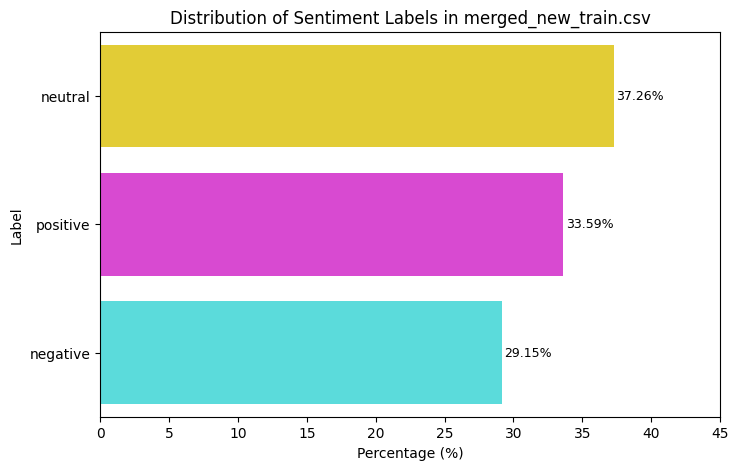


merged_new_train.csv

Label               Count
-------------------------
positive            12238
neutral             13577
negative            10622
-------------------------
Total               36437


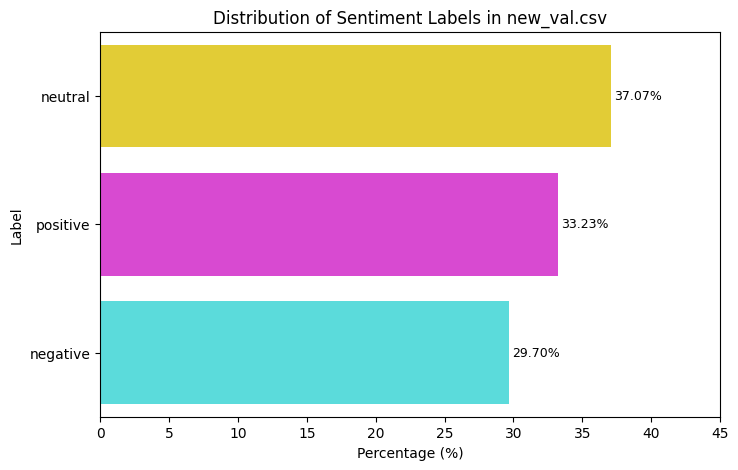


new_val.csv

Label               Count
-------------------------
neutral              1930
positive             1730
negative             1546
-------------------------
Total                5206


In [20]:
# Load raw files
files = ['Training Data/Sentiment Analysis Data/merged_new_train.csv', 'Training Data/Sentiment Analysis Data/new_val.csv']

# Visualize the distribution of both the training and validation sets
for file in files:
    visualize_sentiment_distribution(file)

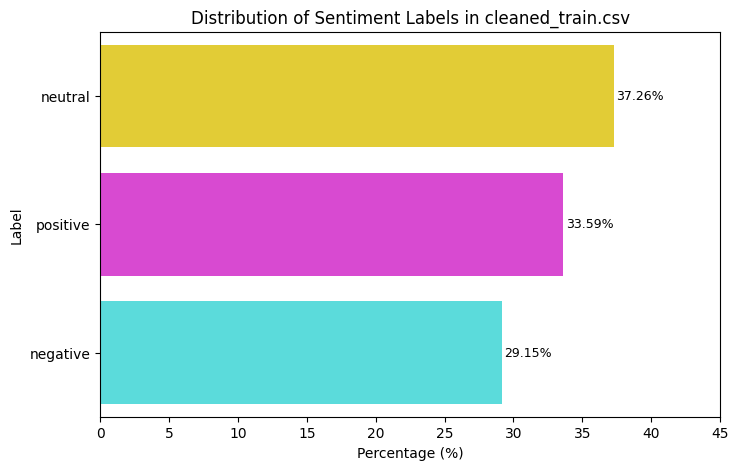


cleaned_train.csv

Label               Count
-------------------------
positive            12238
neutral             13577
negative            10622
-------------------------
Total               36437


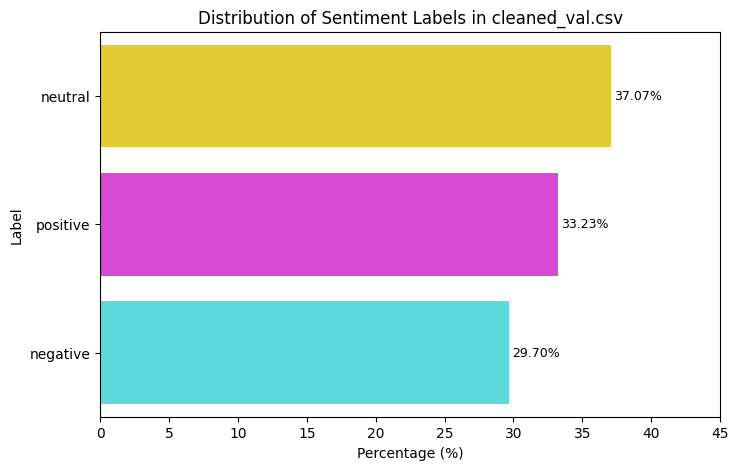


cleaned_val.csv

Label               Count
-------------------------
neutral              1930
positive             1730
negative             1546
-------------------------
Total                5206


In [21]:
# Load cleaned files
files = ['Training Data/Sentiment Analysis Data/cleaned_train.csv', 'Training Data/Sentiment Analysis Data/cleaned_val.csv']

# Visualize the distribution of both the training and validation sets
for file in files:
    visualize_sentiment_distribution(file)

### Test Set (the same test set is used for both sentiment analysis and topic modeling)

#### Distribution Analysis

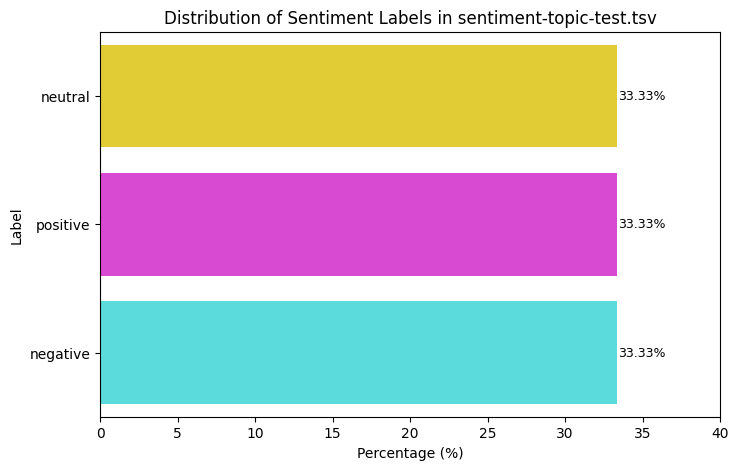

In [22]:
# Visualization of the distribution of provided Test set (from .tsv file)

# Load file
file_path = 'Test Data/sentiment-topic-test.tsv'
df = pd.read_csv(file_path, delimiter='\t')

# Compute the percentage distribution of each sentiment label
sentiment_counts = Counter(df['sentiment'])
total_labels = sum(sentiment_counts.values())
sentiment_percentages = {label: (count / total_labels) * 100 for label, count in sentiment_counts.items()}

# Extract percentages and corresponding colors in the defined order for each class
ordered_labels = ["neutral", "positive", "negative"]
percentages = [sentiment_percentages[label] for label in ordered_labels]
color_map = {"neutral": "#FFE119", "positive": "#F032E6", "negative": "#46F0F0"}
colors = [color_map[label] for label in ordered_labels]

# Create the bar chart (horizontal)
plt.figure(figsize=(8,5))
sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
for index, value in enumerate(percentages):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center', fontsize=9)
plt.xlabel('Percentage (%)')
plt.ylabel('Label')
plt.xlim(0, 40)
filename = os.path.basename(file_path)
plt.title(f'Distribution of Sentiment Labels in {filename}')
plt.show()

### VADER on Test Set

In [25]:
nlp = spacy.load("en_core_web_sm") # Preprocessing with spaCy
vader_model = SentimentIntensityAnalyzer() # Initialize VADER model

def vader_output_to_label(vader_output):
    """
    Convert VADER's compound score to sentiment labels.
    """
    compound = vader_output['compound']

    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    else:
        return 'positive'

# There is an option to turn on and off preprocessing of VADER input (preprocess=False/True).
def run_vader(textual_unit, lemmatize=False, verbose=False, preprocess=False):
    """
    Run VADER on a sentence with optional preprocessing.
    """
    if preprocess == True: # If preprocessing is turned on, preprocess textual units before passing to VADER 
        doc = nlp(textual_unit)
        input_to_vader = []

        for sent in doc.sents:
            for token in sent:
                to_add = token.text
                if lemmatize:
                    to_add = token.lemma_
                    if to_add == '-PRON-':
                        to_add = token.text
                input_to_vader.append(to_add) 

        scores = vader_model.polarity_scores(' '.join(input_to_vader))

        if verbose >= 1:
            print("\nINPUT SENTENCE:", textual_unit)
            print("INPUT TO VADER:", input_to_vader)
            print("VADER OUTPUT:", scores)
    else: # If preprocessing is turned off, feed raw textual units to VADER
        scores = vader_model.polarity_scores(textual_unit)

        if verbose >= 1:
            print("\nINPUT SENTENCE:", textual_unit)
            print("VADER OUTPUT:", scores)

    return scores

def evaluate_vader_on_testset(file_path, lemmatize=False, verbose=False, preprocess=False, print_report=False, misclassification_breakdown=False):
    """
    Run VADER on the test set and compare with ground truth sentiment labels.
    """
    df = pd.read_csv(file_path, delimiter="\t")

    # Dictionaries to store error counts and details for misclassified sentences
    misclassified_counts = {"positive": 0, "negative": 0, "neutral": 0}
    misclassified_sentences = {"positive": [], "negative": [], "neutral": []}

    actual_sentiments = df["sentiment"].tolist()
    sentences = df["sentence"].tolist()

    predicted_sentiments = []

    # Run VADER
    for i in range(len(sentences)):
        vader_output = run_vader(sentences[i], lemmatize=lemmatize, verbose=verbose, preprocess=preprocess)
        predicted_label = vader_output_to_label(vader_output)
        predicted_sentiments.append(predicted_label)

        true_label = actual_sentiments[i]

        # Check for misclassification
        if true_label != predicted_label:
            misclassified_counts[true_label] += 1
            misclassified_sentences[true_label].append((sentences[i], predicted_label, vader_output))

    # If the option is selected, show detailed misclassification breakdown
    if misclassification_breakdown == True:
        print("\nMisclassification Summary")
        print("-" * 50)
        for sentiment, count in misclassified_counts.items():
            print(f"{sentiment.capitalize()} misclassified: {count}")
        print("=" * 50)
        for sentiment, errors in misclassified_sentences.items():
            print(f"\nMisclassified {sentiment.capitalize()} Sentences")
            print("~" * 50)
            for sentence, predicted, vader_scores in errors:
                print(f"\nSentence: {sentence}")
                print(f"Expected: {sentiment}; Predicted: {predicted}")
                print(f"VADER Scores: {vader_scores}")
                print("*" * 50)

    # If the option is selected, show classification report
    if print_report == True:
        print("\nVADER Sentiment Analysis Performance:")
        print(classification_report(actual_sentiments, predicted_sentiments, digits=4))

In [26]:
# First print only classification report for better visibility
# Without preprocessing, the performance increases slightly, therefore, we have decided to turn it off
df_vader_results = evaluate_vader_on_testset(file_path='Test Data/sentiment-topic-test.tsv', lemmatize=False, verbose=False, preprocess=False, 
                                             print_report=True, misclassification_breakdown=False)

# Run again with detailed breakdown of misclassifications for detailed analysis
df_vader_results = evaluate_vader_on_testset(file_path='Test Data/sentiment-topic-test.tsv', lemmatize=False, verbose=False, preprocess=False, 
                                             print_report=False, misclassification_breakdown=True)


VADER Sentiment Analysis Performance:
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         6
     neutral     0.3333    0.5000    0.4000         6
    positive     0.4286    0.5000    0.4615         6

    accuracy                         0.3333        18
   macro avg     0.2540    0.3333    0.2872        18
weighted avg     0.2540    0.3333    0.2872        18


Misclassification Summary
--------------------------------------------------
Positive misclassified: 3
Negative misclassified: 6
Neutral misclassified: 3

Misclassified Positive Sentences
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Sentence: The atmosphere at the stadium tonight was electric.
Expected: positive; Predicted: neutral
VADER Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
**************************************************

Sentence: It had me hooked from the first chapter.
Expected: positive; Predicted: neutral
VADER Scores: {'neg': 0.0, '

### Training BERT

In [ ]:
# We have used Google Colab for training BERT

# Import files on Colab
from google.colab import files
uploaded = files.upload()

Saving sentiment-topic-test.tsv to sentiment-topic-test.tsv


In [ ]:
# Mount Google Drive to store the model checkpoints there to avoid memory issues on Colab
from google.colab import drive
drive.mount('/content/drive')

output_dir = "/content/drive/My Drive/BERT_RoBERTa_Models"

os.makedirs(output_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read cleaned data locally (used when running on our devices)
# cleaned_train = pd.read_csv("Training Data/Sentiment Analysis Data/cleaned_train.csv", delimiter=",")
# cleaned_val = pd.read_csv("Training Data/Sentiment Analysis Data/cleaned_val.csv", delimiter=",")
# sentiment_test = pd.read_csv("Test Data/sentiment-topic-test.tsv", delimiter="\t")

# Read cleaned data when running the notebook on Colab
cleaned_train = pd.read_csv("cleaned_train.csv", delimiter=",")
cleaned_val = pd.read_csv("cleaned_val.csv", delimiter=",")
sentiment_test = pd.read_csv("sentiment-topic-test.tsv", delimiter="\t")

# Rename columns so they match across all datasets
cleaned_train = cleaned_train[['text', 'sentiment']].rename(columns={'text': 'text', 'sentiment': 'labels'})
cleaned_val = cleaned_val[['text', 'sentiment']].rename(columns={'text': 'text', 'sentiment': 'labels'})
sentiment_test = sentiment_test[['sentence', 'sentiment']].rename(columns={'sentence': 'text', 'sentiment': 'labels'})

# BERT requires numerical labels --> change to 0/1/2
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

cleaned_train['labels'] = cleaned_train['labels'].map(label_map)
cleaned_val['labels'] = cleaned_val['labels'].map(label_map)
sentiment_test['labels'] = sentiment_test['labels'].map(label_map)

In [ ]:
# Defining model's configuration
model_args = ClassificationArgs()
model_args.overwrite_output_dir = True  # Overwrite any saved models in the output directory
model_args.evaluate_during_training = True  # Evaluate during training
model_args.num_train_epochs = 10
model_args.train_batch_size = 32 # Batch size of 32 provided a good balance between training speed and stability
model_args.learning_rate = 4e-6
model_args.max_seq_length = 512 # Max length of input tokens (BERT supports up to 512) in order to handle longer text
model_args.fp16 = True # Enable mixed precision training for faster training and lower memory usage
model_args.gradient_accumulation_steps = 2

# Early stopping to prevent overfitting
model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = 'eval_loss'
model_args.early_stopping_metric_minimize = True
model_args.early_stopping_patience = 5
model_args.evaluate_during_training_steps = 32

# Save the model
model_args.output_dir = output_dir
model_args.best_model_dir = os.path.join(output_dir, "best_model")

steps_per_epoch = int(np.ceil(len(cleaned_train) / float(model_args.train_batch_size)))
print(f'Each epoch will have {steps_per_epoch} steps.')

Each epoch will have 1139 steps.


In [ ]:
# Load the model
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args=model_args, use_cuda=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Train the model
_, history = model.train_model(cleaned_train, eval_df=cleaned_val, output_dir=output_dir)

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/1139 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:01<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/1139 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/1139 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


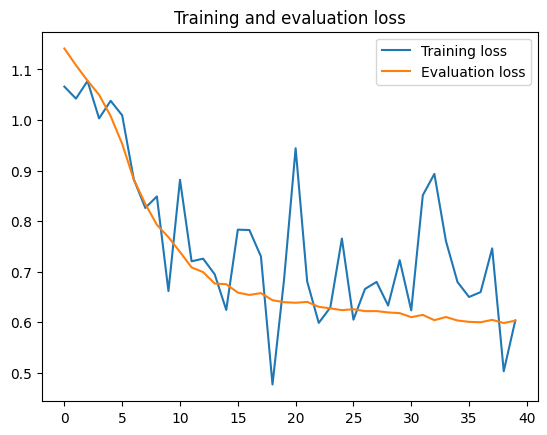

In [ ]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

### BERT on Test Set

In [ ]:
predicted, probabilities = model.predict(sentiment_test.text.to_list())
sentiment_test['predicted'] = predicted

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [ ]:
# Results
print(classification_report(sentiment_test['labels'], sentiment_test['predicted'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.6667    0.8000         6
           1     0.8571    1.0000    0.9231         6
           2     0.8571    1.0000    0.9231         6

    accuracy                         0.8889        18
   macro avg     0.9048    0.8889    0.8821        18
weighted avg     0.9048    0.8889    0.8821        18



In [ ]:
# Print misclassified examples
misclassified = sentiment_test[sentiment_test['predicted'] != sentiment_test['labels']]
print(misclassified)

                                                 text  labels  predicted
16  It's really incredibly impressive to mess up s...       0          2
17  The only way it's helped me is by keeping my t...       0          1


### Comparison between VADER and BERT: Statistical Analysis

In [ ]:
# Define the total number of instances
n_total = 18

# Define metrics for VADER (from the classification report)
metrics_vader = {
    "precision": np.array([0.00, 0.3333, 0.4286]),
    "recall": np.array([0.00, 0.50, 0.50]),
    "f1-score": np.array([0.00, 0.40, 0.4615]),
    "accuracy": np.array([0.3333])
}

# Define metrics for BERT (from the classification report)
metrics_bert = {
    "precision": np.array([1.00, 0.8571, 0.8571]),
    "recall": np.array([0.6667, 1.00, 1.00]),
    "f1-score": np.array([0.80, 0.9231, 0.9231]),
    "accuracy": np.array([0.8889])
}

# Convert average metric scores (proportions) into estimated counts of correct predictions
x_vader_precision = int(metrics_vader["precision"].mean() * n_total)
x_bert_precision = int(metrics_bert["precision"].mean() * n_total)
x_vader_recall = int(metrics_vader["recall"].mean() * n_total)
x_bert_recall = int(metrics_bert["recall"].mean() * n_total)
x_vader_f1 = int(metrics_vader["f1-score"].mean() * n_total)
x_bert_f1 = int(metrics_bert["f1-score"].mean() * n_total)
x_vader_accuracy = int(metrics_vader["accuracy"].mean() * n_total)
x_bert_accuracy = int(metrics_bert["accuracy"].mean() * n_total)

# Perform the proportions Z-test
z_precision, p_precision = proportions_ztest([x_vader_precision, x_bert_precision], [n_total, n_total], alternative='smaller')
z_recall, p_recall = proportions_ztest([x_vader_recall, x_bert_recall], [n_total, n_total], alternative='smaller')
z_f1, p_f1 = proportions_ztest([x_vader_f1, x_bert_f1], [n_total, n_total], alternative='smaller')
z_accuracy, p_accuracy = proportions_ztest([x_vader_accuracy, x_bert_accuracy], [n_total, n_total], alternative='smaller')

# Save the results of all metrics in a dataframe
z_test_results_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-Score", "Accuracy"],
    "VADER Mean": [metrics_vader["precision"].mean(), metrics_vader["recall"].mean(), metrics_vader["f1-score"].mean(), metrics_vader["accuracy"].mean()],
    "BERT Mean": [metrics_bert["precision"].mean(), metrics_bert["recall"].mean(), metrics_bert["f1-score"].mean(), metrics_bert["accuracy"].mean()],
    "Z-statistic": [z_precision, z_recall, z_f1, z_accuracy],
    "p-value": [p_precision, p_recall, p_f1, p_accuracy]
})

# Print the Z-test results
print("Z-Test for Proportions Results:")
print(z_test_results_df)

# Set the significance level
alpha = 0.05

# Print the results with an interpretation: if the H0 is rejected or not
print("\n Interpretation")
for i, row in z_test_results_df.iterrows():
    if row["p-value"] < alpha:
        print(f"-> {row['Metric']}: Significant difference (reject null hypothesis, BERT significantly outperforms VADER)")
    else:
        print(f"-> {row['Metric']}: No significant difference (fail to reject null hypothesis)")

Z-Test for Proportions Results:
      Metric  VADER Mean  BERT Mean  Z-statistic   p-value
0  Precision    0.253967   0.904733    -4.024922  0.000028
1     Recall    0.333333   0.888900    -3.418817  0.000314
2   F1-Score    0.287167   0.882067    -3.354102  0.000398
3   Accuracy    0.333300   0.888900    -3.718679  0.000100

 Interpretation
-> Precision: Significant difference (reject null hypothesis, BERT significantly outperforms VADER)
-> Recall: Significant difference (reject null hypothesis, BERT significantly outperforms VADER)
-> F1-Score: Significant difference (reject null hypothesis, BERT significantly outperforms VADER)
-> Accuracy: Significant difference (reject null hypothesis, BERT significantly outperforms VADER)


# 3. Topic Classification

### Training & Validation Sets (the dataset did not come split, so we split it later on)

#### Data Preprocessing 

In [ ]:
# Load Spacy model for named entity recognition
nlp = spacy.load("en_core_web_sm")

# Ensure consistent language detection
DetectorFactory.seed = 0  

# Load dataset
train_df_tm = pd.read_csv("Training Data/Topic Classification Data/topic_train.csv")

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to remove emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

# Function to remove common emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(r"""
        (:|;|=|X|8)  
        (-|')?       
        (\)|D|P|O|o|\(|/|\\|\*|3|\||\]|\[)
        |<3          
        |¯\\_\(ツ\)_/¯ 
        |o_O|O_o|o.o|O.O  
        |:-?[\[\]{}()<>]
        |:\'\(|:\'\)  
    """, re.VERBOSE)
    return emoticon_pattern.sub('', text)

# Function to check if text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Function to preserve named entities
def preserve_named_entities(text):
    doc = nlp(text)
    entities = {ent.text for ent in doc.ents}  # Extract named entities
    for entity in entities:
        text = text.replace(entity, entity.replace(" ", "_"))  # Convert to bigram form
    return text

# Function to remove special characters and extra spaces
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    return text

# Function to count words correctly (avoiding symbols & short tokens)
def count_words(text):
    words = re.findall(r'\b[a-zA-Z]{2,}\b', text)  # Words with at least 2 letters
    return len(words)

# Function to apply tokenization, stop-word removal, and stemming
def preprocess_text(text):
    text = remove_emojis(text)  
    text = remove_emoticons(text)  
    text = clean_text(text) 
    text = preserve_named_entities(text)  
    tokens = word_tokenize(text)  # Tokenize
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # Stemming & stop-word removal
    return " ".join(tokens)

# Apply preprocessing pipeline
train_tm_clean = train_df_tm.copy()
train_tm_clean['review'] = train_tm_clean['review'].astype(str).map(preprocess_text, na_action='ignore')

# Remove non-English reviews
train_tm_clean = train_tm_clean[train_tm_clean['review'].apply(is_english)]

# Remove meaningless reviews (reviews with less than 3 words)
train_tm_clean = train_tm_clean[train_tm_clean['review'].apply(count_words) > 3]

# Reset index after filtering
train_tm_clean.reset_index(drop=True, inplace=True)

# Save cleaned dataset
train_tm_clean.to_csv("Training Data/Topic Classification Data/train_tm_clean_NB.csv", index=False)

#### Distribution Analysis

In [ ]:
def visualize_topic_distribution(file_path):
    '''
    Reads a CSV file and displays a horizontal bar chart showing the percentage distribution of topic labels.
    '''
    # Load file
    df = pd.read_csv(file_path)

    # Compute the percentage distribution of each topic label
    topic_counts = Counter(df['label'])
    total_labels = sum(topic_counts.values())
    topic_percentages = {label: (count / total_labels) * 100 for label, count in topic_counts.items()}

    # Extract percentages and corresponding colors in the defined order for each class
    ordered_labels = ["sports", "movie", "book"]
    percentages = [topic_percentages[label] for label in ordered_labels]
    color_map = {"sports": "#0082C8", "movie": "#3CB44B", "book": "#E6194B"}
    colors = [color_map[label] for label in ordered_labels]

    # Create the bar chart (horizontal)
    plt.figure(figsize=(8, 5))
    sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
    for index, value in enumerate(percentages):
        plt.text(value + 0.2, index, f'{value:.2f}%', va='center', fontsize=9)
    plt.xlabel('Percentage (%)')
    plt.ylabel('Label')
    plt.xlim(0, 50)
    filename = os.path.basename(file_path)
    plt.title(f'Distribution of Topic Labels in {filename}')
    plt.show()

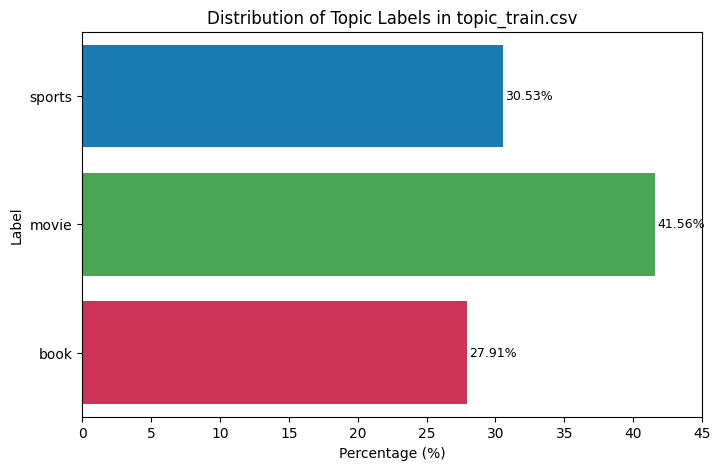

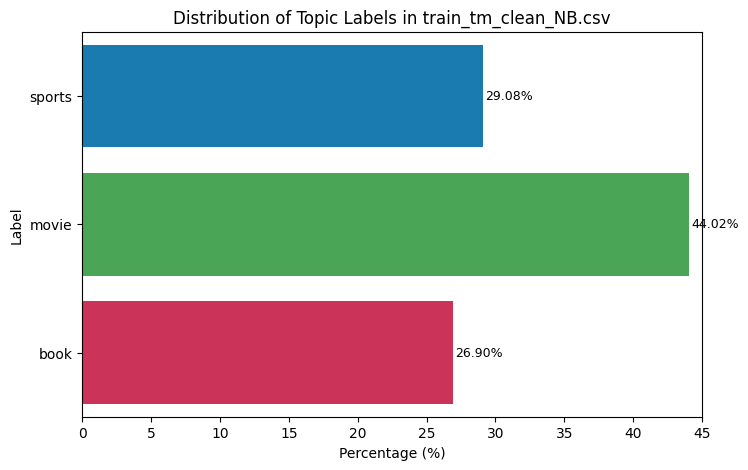

In [10]:
# Distribution of topic labels in original training dataset and the cleaned dataset
files = ['Training Data/Topic Classification Data/topic_train.csv', \
        'Training Data/Topic Classification Data/train_tm_clean_NB.csv']

for file in files:
        visualize_topic_distribution(file)

### Test Set (the same test set is used for both sentiment analysis and topic modeling)

#### Distribution Analysis

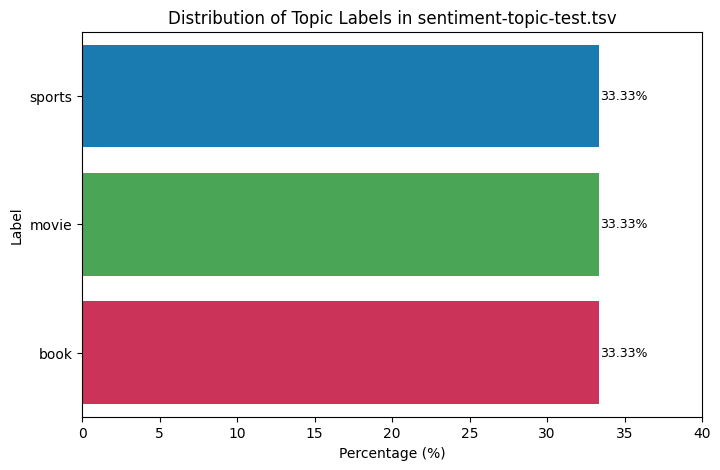

In [ ]:
# Visualization of the distribution of provided Test set (from .tsv file)

# Load file
file_path = 'Test Data/sentiment-topic-test.tsv'
df = pd.read_csv(file_path, delimiter='\t')

# Compute the percentage distribution of each topic label
topic_counts = Counter(df['topic'])
total_labels = sum(topic_counts.values())
topic_percentages = {label: (count / total_labels) * 100 for label, count in topic_counts.items()}

# Extract percentages and corresponding colors in the defined order for each class
ordered_labels = ["sports", "movie", "book"]
percentages = [topic_percentages[label] for label in ordered_labels]
color_map = {"sports": "#0082C8", "movie": "#3CB44B", "book": "#E6194B"}
colors = [color_map[label] for label in ordered_labels]

# Create the bar chart (horizontal)
plt.figure(figsize=(8, 5))
sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
for index, value in enumerate(percentages):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center', fontsize=9)
plt.xlabel('Percentage (%)')
plt.ylabel('Label')
plt.xlim(0, 40)
filename = os.path.basename(file_path)
plt.title(f'Distribution of Topic Labels in {filename}')
plt.show()

### Feature Engineering

In [2]:
# Load cleaned dataset
df = pd.read_csv("Training Data/Topic Classification Data/train_tm_clean_NB.csv")

# Remove duplicate reviews
df = df.drop_duplicates(subset=["review"]).reset_index(drop=True)

# Balance dataset using undersampling
class_counts = df["label"].value_counts()
min_size = class_counts.min()
balanced_df = pd.DataFrame(columns=df.columns)

for label in class_counts.index:
    class_subset = df[df["label"] == label]
    sampled_subset = class_subset.sample(n=min_size, random_state=8)
    balanced_df = pd.concat([balanced_df, sampled_subset])

balanced_df = shuffle(balanced_df, random_state=8).reset_index(drop=True)

# Feature Engineering: TF-IDF 
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(balanced_df['review'])

# Convert to DataFrames and concatenate with original labels
tfidf_sparse = pd.DataFrame.sparse.from_spmatrix(tfidf_features, columns=[f"tfidf_{i}" for i in range(tfidf_features.shape[1])])

final_df = pd.concat([balanced_df[['label']], tfidf_sparse], axis=1) # Not saved as a csv due to a very long saving time

### Model Training and Hyperparameter Optimization

In [ ]:
df = final_df  # Assuming the balanced dataset is already prepared

# Extract labels and features
y = df['label']
X_tfidf = df.filter(like="tfidf_")  

# Split dataset into train (80%) and validation (20%) with stratification
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=8)

# Optuna function for TF-IDF Naive Bayes
def objective_tfidf(trial):
    '''
    Objective function for Optuna to optimize MultinomialNB hyperparameters.
    '''
    alpha = trial.suggest_float('alpha', 0.001, 10.0, log=True)  # Tune alpha
    fit_prior = trial.suggest_categorical('fit_prior', [True, False])  # Tune fit_prior
    
    model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    model.fit(X_train_tfidf, y_train_tfidf)
    
    # Evaluate on validation set
    y_pred = model.predict(X_val_tfidf)
    score = accuracy_score(y_val_tfidf, y_pred)
    
    return score

# Run Optuna hyperparameter optimization aiming to maximize classification accuracy over 100 trials
study_tfidf = optuna.create_study(direction='maximize')
study_tfidf.optimize(objective_tfidf, n_trials=100)
best_params_tfidf = study_tfidf.best_params
print(f"Best parameters for TF-IDF: {best_params_tfidf}")

# Best TF-IDF model
model_tfidf = MultinomialNB(alpha=best_params_tfidf['alpha'], fit_prior=best_params_tfidf['fit_prior'])
model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = model_tfidf.predict(X_val_tfidf)
print("\nTF-IDF Classification Report (Validation Set):\n", classification_report(y_val_tfidf, y_pred_tfidf, digits=4))

joblib.dump(model_tfidf, "optimized_multinomial_nb_tfidf.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

[I 2025-03-29 23:05:56,536] A new study created in memory with name: no-name-b3937c8a-e981-406c-b928-1866c9ef2340
[I 2025-03-29 23:05:56,896] Trial 0 finished with value: 0.9705947996875349 and parameters: {'alpha': 2.358045717431719, 'fit_prior': True}. Best is trial 0 with value: 0.9705947996875349.
[I 2025-03-29 23:05:57,138] Trial 1 finished with value: 0.9667447829483317 and parameters: {'alpha': 0.0013459682307317188, 'fit_prior': False}. Best is trial 0 with value: 0.9705947996875349.
[I 2025-03-29 23:05:57,380] Trial 2 finished with value: 0.9688650820220958 and parameters: {'alpha': 0.6351074204309564, 'fit_prior': True}. Best is trial 0 with value: 0.9705947996875349.
[I 2025-03-29 23:05:57,605] Trial 3 finished with value: 0.9670237696685637 and parameters: {'alpha': 0.008543527401773528, 'fit_prior': True}. Best is trial 0 with value: 0.9705947996875349.
[I 2025-03-29 23:05:57,832] Trial 4 finished with value: 0.9670237696685637 and parameters: {'alpha': 0.00672285685764425

Best parameters for TF-IDF: {'alpha': 7.430739850967651, 'fit_prior': True}

TF-IDF Classification Report (Validation Set):
               precision    recall  f1-score   support

        book     0.9890    0.9459    0.9670      5974
       movie     0.9347    0.9965    0.9646      5974
      sports     0.9985    0.9759    0.9870      5974

    accuracy                         0.9728     17922
   macro avg     0.9740    0.9728    0.9729     17922
weighted avg     0.9740    0.9728    0.9729     17922



['tfidf_vectorizer.pkl']

In [4]:
# Print total counts
print("Total number of instances:")
print(f"Training set: {len(y_train_tfidf)}")
print(f"Validation set: {len(y_val_tfidf)}")

# Print detailed label distributions
print("\nTraining Set Label Distribution:")
print( y_train_tfidf.value_counts())
print("\nValidation Set Label Distribution:")
print( y_val_tfidf.value_counts())

Total number of instances:
Training set: 71685
Validation set: 17922

Training Set Label Distribution:
label
book      23895
sports    23895
movie     23895
Name: count, dtype: int64

Validation Set Label Distribution:
label
movie     5974
book      5974
sports    5974
Name: count, dtype: int64


### Model Evaluation on Test Set

In [5]:
# Load the test dataset with only the required columns: sentence and topic
test_df = pd.read_csv("Test Data/sentiment-topic-test.tsv", sep="\t", usecols=["sentence", "topic"], engine="python")

# Here we are using the optimized models from the Optuna study
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Load the optimized MultinomialNB model trained on TF-IDF features
model_tfidf = joblib.load("optimized_multinomial_nb_tfidf.pkl")

# Transform the test sentences using the TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(test_df['sentence'])
X_test_df = pd.DataFrame(X_test_tfidf.toarray(), columns=model_tfidf.feature_names_in_)

# Extract the true topic labels
y_test = test_df['topic']

# Make predictions using the optimized TF-IDF model
y_pred_tfidf = model_tfidf.predict(X_test_df)

# Display classification performance on the test set
print("\nTF-IDF Classification Report (Test Set):")
print(classification_report(y_test, y_pred_tfidf, digits=4))

# Identify and store misclassified examples 
misclassified_tfidf = test_df.loc[y_test != y_pred_tfidf].copy()
misclassified_tfidf.loc[:, "Predicted_TFIDF"] = y_pred_tfidf[y_test != y_pred_tfidf]

# Display the first 10 misclassified samples
print(misclassified_tfidf[['sentence', 'topic', 'Predicted_TFIDF']].head(10))



TF-IDF Classification Report (Test Set):
              precision    recall  f1-score   support

        book     0.7500    1.0000    0.8571         6
       movie     0.8333    0.8333    0.8333         6
      sports     1.0000    0.6667    0.8000         6

    accuracy                         0.8333        18
   macro avg     0.8611    0.8333    0.8302        18
weighted avg     0.8611    0.8333    0.8302        18

                                             sentence   topic Predicted_TFIDF
7   How do you concede three goals in ten minutes?...  sports           movie
12  I don't get how was it supposed to work withou...   movie            book
13  It's still 0-0 so far, so way too early to tel...  sports            book
